In [1]:
# python imports
import os
import time
import functools

import numpy as np
from scipy import stats
from scipy.stats import uniform, norm, t as tdist, ttest_ind

In [2]:
# setup graphs
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib import rc

plt.rcParams['figure.figsize'] = 8, 3.5
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['figure.dpi'] = 100;

# numpy print format
np.set_printoptions(linewidth=120, precision=4, suppress=False, formatter={'float': '{:5.3e}'.format})

In [3]:
# local imports
import util.tests as tests
import util.dwdb_reader as io
import util.func as f


In [4]:
small_value = 1e-300
tvla_thrd = 4.5 * np.sqrt(2)

tracenum = 1000
step = 50
# Not needed now
# sample_start = 120 # 30  100    # 40
# sample_end =   130 # 50  500    # 180
# rlen = sample_end - sample_start

PROJECT_ROOT_DIR=os.getcwd()
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(IMAGES_PATH): os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load traces and classification

In [5]:
# Read first sample point, split by classification (2 traces, c1 and c2)
# ntraces = 18
# dsrtp = io.dwdb_reader(r'TP_db.sigma.60.samples.1000/log.dwdb', r'TP_db.sigma.60.samples.1000')
# dsrfp = io.dwdb_reader(r'FP_db.sigma.50.samples.1000/log.dwdb', r'FP_db.sigma.50.samples.1000')
# ntraces = 24
# dsrtp = io.dwdb_reader(r'TP_db.sigma.55.samples.500/log.dwdb', r'TP_db.sigma.55.samples.500')
# dsrfp = io.dwdb_reader(r'FP_db.sigma.50.samples.500/log.dwdb', r'FP_db.sigma.50.samples.500')
ntraces = 140
dsrtp = io.dwdb_reader(r'TP_db.sigma.55.samples.400/log.dwdb', r'TP_db.sigma.55.samples.400')
dsrfp = io.dwdb_reader(r'FP_db.sigma.55.samples.400/log.dwdb', r'FP_db.sigma.55.samples.400')
# ntraces = 500 # Original (sigmas 4.5?, 4.5?)
# dsrtp = io.dwdb_reader(r'TP_db/log.dwdb', r'TP_db')
# dsrfp = io.dwdb_reader(r'FP_db/log.dwdb', r'FP_db')

nsamples = ntraces

print("Reading TP traces")
data_batch_tp, meta_batch_tp = dsrtp.read_batch(ntraces)
print("Done")

print("Reading FP traces")
data_batch_fp, meta_batch_fp = dsrfp.read_batch(ntraces)
print("Done")

tp_range, fp_range = slice(0,nsamples), slice(0,nsamples)
data_batch0, meta_batch0 = data_batch_fp[fp_range], meta_batch_fp[fp_range]
data_batch1, meta_batch1 = data_batch_tp[tp_range], meta_batch_tp[tp_range]

Reading TP traces
Done
Reading FP traces
Done


In [6]:
# Convert traces to numpy and cut the data amount
traces_fp = np.asarray(data_batch0)#[:,:300]
traces_tp = np.asarray(data_batch1)#[:,:300]
assert traces_fp.shape == traces_tp.shape
traces_fp.shape, traces_tp.shape

((140L, 400L), (140L, 400L))

In [7]:
# Extract classifiers, convert to numpy
meta_prep = [m['other'].split() for m in meta_batch0]
classifiers = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('s=')]
classifiers = [str(int(c)-1) for c in classifiers]
classifiers_fp = np.asarray(classifiers).reshape(-1, 2)
meta_prep = [m['other'].split() for m in meta_batch1]
classifiers = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('s=')]
classifiers_tp = np.asarray(classifiers).reshape(-1, 2)

# classifiers_fp, classifiers_tp
classifiers_fp.shape, classifiers_tp.shape

((70L, 2L), (70L, 2L))

In [8]:
# Ensure dbs classified correctly
ct_fp, ct_tp = classifiers_fp.astype(int), classifiers_tp.astype(int)
assert np.all(ct_tp[:,1] == ct_fp[:,1])
assert np.all(ct_tp[:,0] != ct_fp[:,1])

In [9]:
# Postprocessing 1 (Convert to dwdb format)
ds_num, tr_num = traces_fp.shape
# 1. 2 traces should be transposed and merged in 1 sample point
traces_fp = traces_fp.reshape(ds_num//2, -1)
traces_tp = traces_tp.reshape(ds_num//2, -1)
# 2. classifiers should be stretched as the 1st half of the sample point is R1 and 2nd one is R2
classifiers_fp = np.repeat(classifiers_fp[0], tr_num)
classifiers_tp = np.repeat(classifiers_tp[0], tr_num)
# traces_np[:4], classifiers_np[:4]
print(traces_fp.shape, classifiers_fp.shape, traces_tp.shape, classifiers_tp.shape)
print(np.all(classifiers_fp == classifiers_tp))

((70L, 800L), (800L,), (70L, 800L), (800L,))
True


In [10]:
# Postprocessing 2 (make multipoint (TP, FP, TP, FP, ...))
# Given that first 1000 traces are classified 0s and second 1000 are 1s, 
# merge traces to one dataset, where even sample point are TP and odd ones are FP
# Classifires are the same
pt_num, tr_num = traces_fp.shape
traces_np = np.empty((tr_num, 2*pt_num))
for i in range(pt_num):
    traces_np[:,2*i]   = traces_tp[i]
    traces_np[:,2*i+1] = traces_fp[i]
classifiers_np = classifiers_fp
traces_np.shape

(800L, 140L)

In [11]:
# Sanity check, print border
print(traces_np[197:203,:4])
print(classifiers_np[197:203])

[[5.000e+00 4.674e+00 5.000e+00 5.591e+00]
 [5.000e+00 4.494e+00 5.000e+00 4.345e+00]
 [5.000e+00 2.015e+00 5.000e+00 4.766e+00]
 [5.000e+00 6.865e+00 5.000e+00 6.872e+00]
 [5.000e+00 3.189e+00 5.000e+00 7.782e+00]
 [5.000e+00 4.538e+00 5.000e+00 1.139e+00]]
['0' '0' '0' '0' '0' '0']


In [12]:
# Postprocessing 3 (randomize traces)
# classifiers go as [000 all zeros, 111 all ones], it breaks evolution
# data should be shuffled, taking classifiers_fp as a common one
tracenum = tr_num # update tracenum to the actual value
perm_ind = np.random.permutation(np.arange(tracenum))
traces_np, classifiers_np = traces_np[perm_ind], classifiers_np[perm_ind]
traces_np.shape, classifiers_np.shape

((800L, 140L), (800L,))

In [13]:
# Make sure traces are shuffled right, print the border
print(traces_np[197:203,:4])
print(classifiers_np[197:203])

[[5.000e+00 2.828e+00 5.000e+00 7.665e+00]
 [1.585e+00 2.854e+00 2.544e+00 5.496e+00]
 [5.000e+00 4.165e+00 5.000e+00 6.758e+00]
 [5.000e+00 3.921e+00 5.000e+00 5.260e+00]
 [6.245e+00 5.765e+00 1.576e+00 6.199e+00]
 [-8.220e-01 2.375e+00 4.295e+00 6.557e+00]]
['0' '1' '0' '0' '1' '1']


## Sanity check. Make sure it leaks

In [14]:
np.mean(traces_np, axis=0)[:4], np.var(traces_np, axis=0)[:4]

(array([4.738e+00, 5.003e+00, 5.250e+00, 4.862e+00]),
 array([1.733e+00, 4.214e+00, 1.546e+00, 3.518e+00]))

In [15]:
tt_orig = tests.fvr_ttest(traces_np, classifiers_np)
att = np.abs(tt_orig)
att.shape
# np.max(att), np.min(att)

(140L,)

<IPython.core.display.Javascript object>


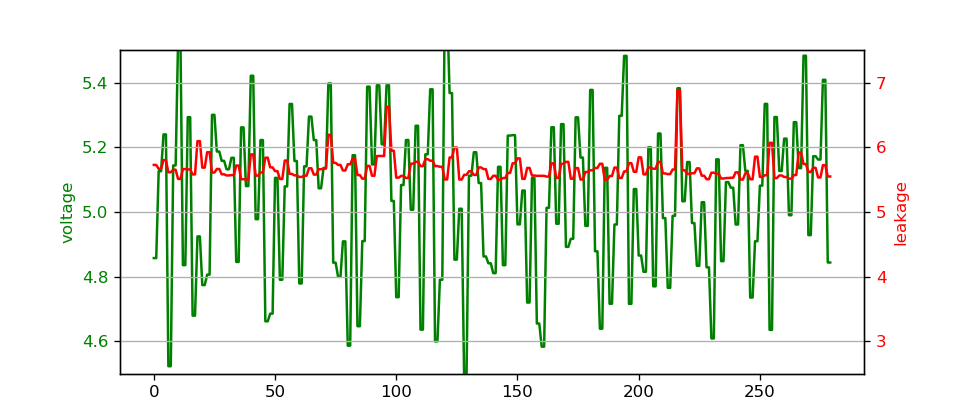

In [16]:
rangex = np.arange(2)
voltage_trace1 = np.mean(traces_np[:100], axis=0)
voltage_trace = np.repeat(voltage_trace1, len(rangex))
tt_trace = np.repeat(np.abs(tt_orig), len(rangex))

fig, ax1 = plt.subplots()
ax1.set_ylabel('voltage', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.set_ylabel('leakage', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_ylim(4.5, 5.5)
ax1.plot(voltage_trace, color='g', zorder=10)   # signal
ax2.set_ylim(2.5, 7.5)
ax2.plot(tt_trace, color='r', zorder=0)     # leak
plt.grid()
plt.show()

## Evolution

In [17]:
evo_step = step
evo_tstat = np.empty(((tracenum+1)/evo_step, traces_np.shape[1]))
evo_xrange = np.arange(evo_step, tracenum+1, evo_step)
for i, ex in enumerate(evo_xrange):
    start = time.time()
    tt = tests.fvr_ttest(traces_np[:ex], classifiers_np[:ex])
    evo_tstat[i,:] = tt
#     if i % evo_step == 0:
#         print("Trace count: {}, tt: {}, done in {}".format(ex, tt, time.time() - start))
evo_tstat = np.abs(evo_tstat) # comment out for intermediates

# Max leakage info
tr_num, max_leak_pt = np.unravel_index(np.argmax(evo_tstat), evo_tstat.shape)
max_leak_val, max_leak_at = evo_tstat[tr_num, max_leak_pt], tr_num*evo_step
max_leak_pv = tdist.sf(max_leak_val, max_leak_at)
print("Max leak at point: {}, value: {:5.3e} (pv: {:5.3e}), trace: {}".format(
    max_leak_pt, max_leak_val, max_leak_pv, max_leak_at))

Max leak at point: 108, value: 6.888e+00 (pv: 6.011e-12), trace: 750


<IPython.core.display.Javascript object>


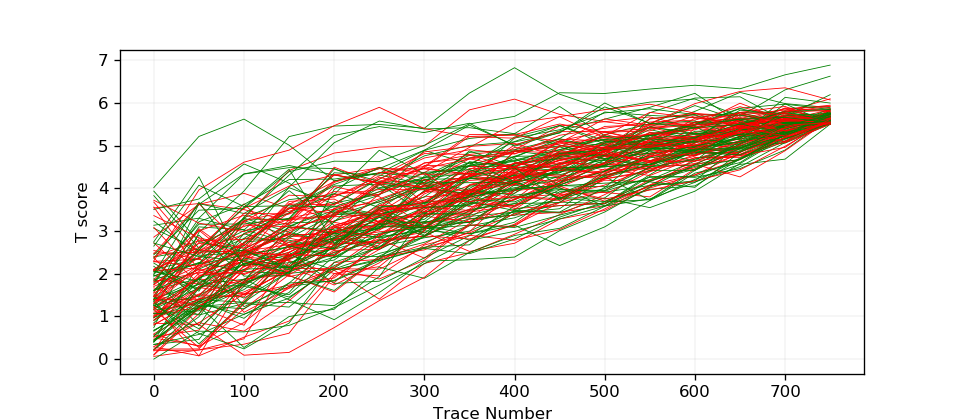

In [18]:
step_num, pt_num = np.shape(evo_tstat)

fig = plt.figure()
plt.ylabel('T score')
plt.xlabel('Trace Number')
# plt.axhline(y=tvla_thrd, color='r', linestyle=':')

x_axis = np.arange(step_num) * evo_step

# leak history for each TP point (even, green)
for j in range(0, pt_num, 2):
    plk = evo_tstat[:, j]
    plt.plot(x_axis, plk, linewidth=0.5, linestyle='-', color = 'g', zorder = j)

# leak history for each FP point (odd, red)
for j in range(1, pt_num, 2):
    plk = evo_tstat[:, j]
    plt.plot(x_axis, plk, linewidth=0.5, linestyle='-', color = 'r', zorder = j)

plt.grid(alpha=.5, linewidth=.25)
plt.show()

## Bootstrapping

In [19]:
pt_num = traces_np.shape[1]
boots_list = [21, 51, 91, 151, 201, 301]  # iterations in a boot
boot_step = 100 #step
boot_till = tracenum
ld_stat = stats.uniform
ld_cdf = ld_stat().cdf

step_ranges = np.linspace(0, boot_till, boot_till/boot_step+1, dtype=np.int)
step_ranges = np.arange(boot_step, boot_till+1, boot_step)

tt_step_per_boot = []  # cannot be numpy array due to different lengths per boot
tp_step_per_boot = []  # cannot be numpy array due to different lengths per boot
ksp_per_boot     = np.empty((len(boots_list), len(step_ranges), pt_num))

start = time.time()
for j, boots in enumerate(boots_list):
    # Run all boots for a step
    res_shape = np.empty((len(step_ranges), pt_num, boots))
    tt_full_per_boot = np.empty_like(res_shape)
    tp_full_per_boot = np.empty_like(res_shape)
    for k, steprange in enumerate(step_ranges):
        tt_full = tt_full_per_boot[k]
        tp_full = tp_full_per_boot[k]
        ks_full = ksp_per_boot[j, k]
#         rng_idxs = np.random.randint(steprange, size=(boots, steprange))  # From the beginning
        rng_idxs = np.random.randint(steprange-boot_step, steprange, size=(boots, boot_step)) # Rrange only
        for i, ri in enumerate(rng_idxs):
            tt_full[:, i] = tests.fvr_ttest(traces_np[ri], classifiers_np[ri]) # calc tt and keep it
            tp_full[:, i] = tdist.sf(tt_full[:,i], steprange)                    # convert tt to pv and keep it
        # Run ks-test for p-value set for each sample point
        for i, pt_boots in enumerate(tp_full):
            ks_full[i] = f.kstest(pt_boots, ld_cdf)[1]                      # keep pv only
#             print(pt_boots[:8])
#             break
#         break
    tt_step_per_boot.append(tt_full_per_boot)  # cannot be numpy array due to different lengths per boot
    tp_step_per_boot.append(tp_full_per_boot)  # cannot be numpy array due to different lengths per boot
print("Bootstrapping for 1000 traces, {} points done in {} sec".format(pt_num, time.time() - start))
ksp_per_boot.shape # boots_list, step_ranges, points

Bootstrapping for 1000 traces, 140 points done in 3.8869998455 sec


(6L, 8L, 140L)

# Bootstrapping vizualization

In [20]:
# Prepare data
ksp_per_boot[np.where(np.isnan(ksp_per_boot))]     = small_value
ksp_per_boot[np.where(ksp_per_boot < small_value)] = small_value

cpalette = ['g', 'r'] # TP green, FP red


N points: 140


<IPython.core.display.Javascript object>


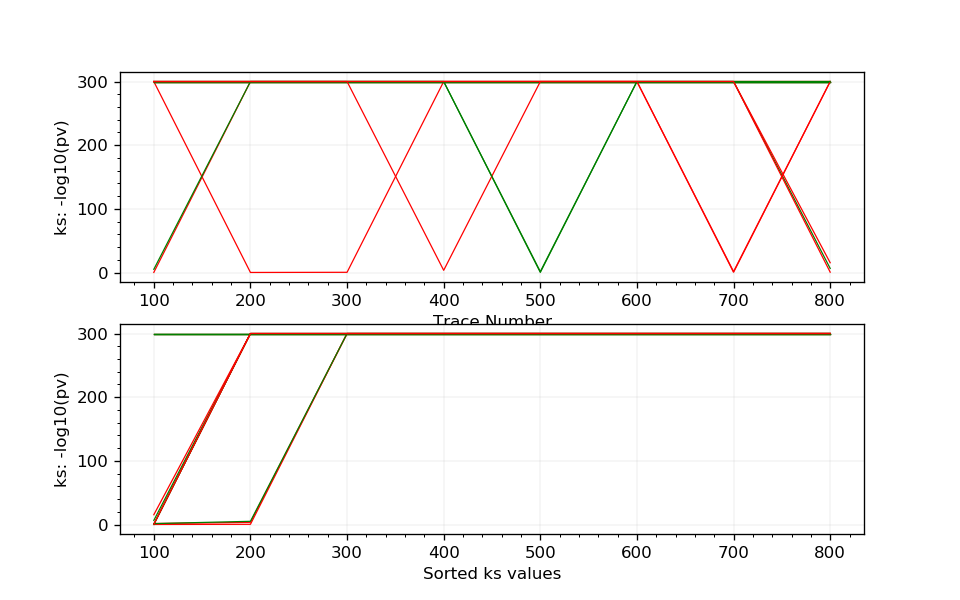

In [23]:
boot_idx = 4

kspv_evo = ksp_per_boot[boot_idx].T  # (pt, step)
res = kspv_evo

pt_num, step_cnt = res.shape
print("N points: {}".format(pt_num))

x_axis = step_ranges

# ks results visualization
fig, axs = plt.subplots(2, sharey=True, figsize=(8, 5))
axs[0].set(xlabel='Trace Number', ylabel='ks: -log10(pv)')
axs[1].set(xlabel='Sorted ks values', ylabel='ks: -log10(pv)')

# Boot evolution for TP (even, green)
for j in range(0, pt_num, 20):
    kspl = -np.log10(res[j]) # Unsorted
    axs[0].plot(x_axis, kspl, linewidth=0.75, color = 'g', zorder = j)
    kspls = np.sort(kspl)         # Sorted
    axs[1].plot(x_axis, kspls, linewidth=0.75, color = 'g', zorder = j)

# Boot evolution for FP (odd, red)
for j in range(1, pt_num, 20):
    kspl = -np.log10(res[j]) # Unsorted
    axs[0].plot(x_axis, kspl, linewidth=0.75, color = 'r', zorder = j)
    kspls = np.sort(kspl)         # Sorted
    axs[1].plot(x_axis, kspls, linewidth=0.75, color = 'r', zorder = j)

for a in axs: a.minorticks_on()
for a in axs: a.set_xticks(x_axis)
for a in axs: a.grid(alpha=.5, linewidth=.25)
plt.show()
# plot_evo.shape, x_axis.shape

# p-value distribution

N points: 140


<IPython.core.display.Javascript object>


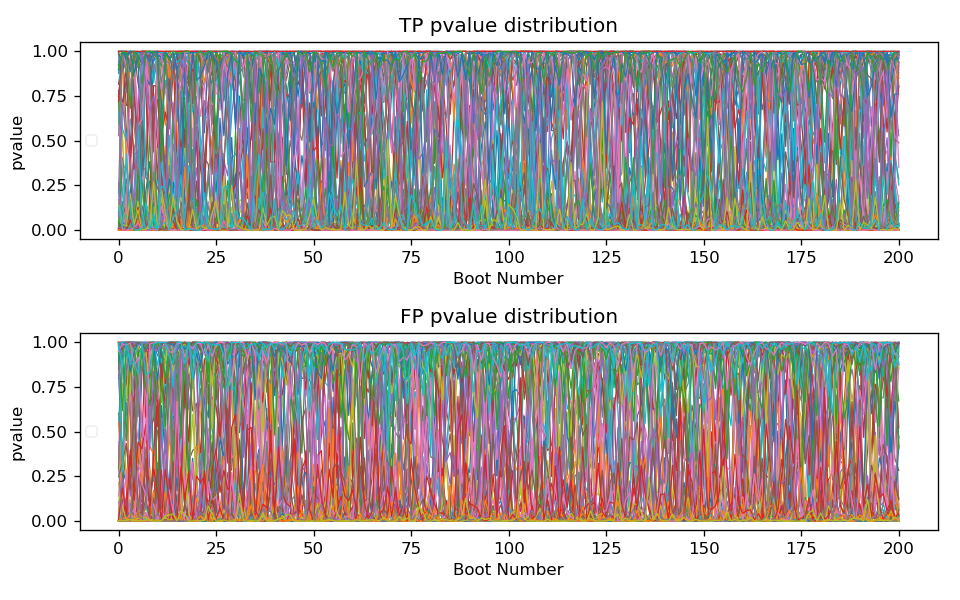

In [24]:
boot_idx, step_idx = 4, 2

# bvs = tt_step_per_boot[boot_idx][step_idx].T  # tt value distribution per boot per step
bvs = tp_step_per_boot[boot_idx][step_idx]      # tt-pv value distribution per boot per step
kspv = ksp_per_boot[boot_idx, step_idx]

# Processing
# one step, one boot set - (points, boots)
res = bvs

pt_num, boot_cnt = res.shape
print("N points: {}".format(pt_num))

x_axis = np.arange(boot_cnt)

fig, axs = plt.subplots(2, sharey=True, figsize=(8, 5))
for a in axs: a.set(xlabel='Boot Number', ylabel='pvalue')

# pv distribution for TP (even, green) and FP (odd, red)
for j in range(0, pt_num, 2):
    axs[0].set_title('TP pvalue distribution')
    y = bvs[j]
#     l = 'pt: {}, ks: {:9.3}, tt: {:5.3}'.format(j, kspv[j], tt_orig[j])
    axs[0].plot(x_axis, y, linewidth=0.75)#, zorder = j, label=l)

for j in range(1, pt_num, 2):
    axs[1].set_title('FP pvalue distribution')
    y = bvs[j]
    l = 'pt: {}, ks: {:9.3}, tt: {:5.3}'.format(j, kspv[j], tt_orig[j])
    axs[1].plot(x_axis, y, linewidth=0.75)#, zorder = j, label=l)

for a in axs: a.legend(loc=6, framealpha=0.3, fontsize=8)
fig.tight_layout()
plt.show()

In [ ]:
res.shape

# Sorted p-value distribution

TP GT 0.5: 28, LT 0.5: 42
FP GT 0.5: 33, LT 0.5: 37


<IPython.core.display.Javascript object>


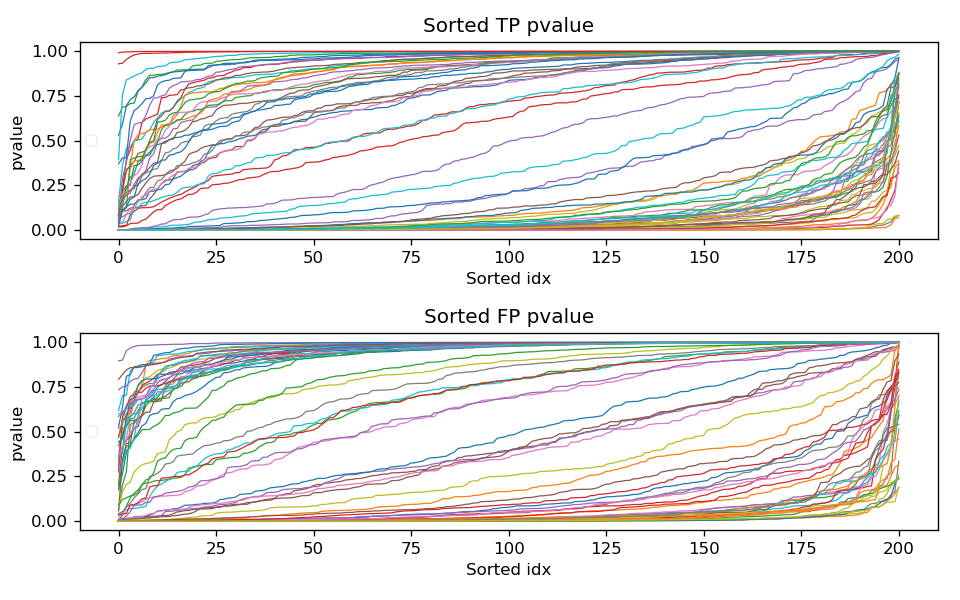

In [25]:
boot_idx, step_idx = 4, 2

# bvs = tt_step_per_boot[boot_idx][step_idx].T  # tt value distribution per boot per step
bvs = tp_step_per_boot[boot_idx][step_idx]      # tt-pv value distribution per boot per step
kspv = ksp_per_boot[boot_idx, step_idx]

# Processing
# one step, one boot set - (points, boots)
res = np.sort(bvs, axis=1) # sort by boots

pt_num, boot_cnt = res.shape
x_axis = np.arange(boot_cnt)
mid_idx = 2*x_axis[len(x_axis)//4]

tf = res[::2].T[mid_idx]
l2 = len(tf[np.where(tf >= 0.5)]), len(tf[np.where(tf < 0.5)])
print("TP GT 0.5: {}, LT 0.5: {}".format(*l2))

tf = res[1::2].T[mid_idx]
l2 = len(tf[np.where(tf >= 0.5)]), len(tf[np.where(tf < 0.5)])
print("FP GT 0.5: {}, LT 0.5: {}".format(*l2))

fig, axs = plt.subplots(2, sharey=True, figsize=(8, 5))
for a in axs: a.set(xlabel='Sorted idx', ylabel='pvalue')

# pv distribution for TP (even, green) and FP (odd, red)
for j in range(0, pt_num, 2):
    axs[0].set_title('Sorted TP pvalue')
    y = np.sort(res[j])
#     l = 'pt: {}, ks: {:9.3}, tt: {:5.3}'.format(j, kspv[j], tt_orig[j])
    axs[0].plot(x_axis, y, linewidth=0.75)#, zorder = j)#, label=l)

for j in range(1, pt_num, 2):
    axs[1].set_title('Sorted FP pvalue')
    y = np.sort(res[j])
#     l = 'pt: {}, ks: {:9.3}, tt: {:5.3}'.format(j, kspv[j], tt_orig[j])
    axs[1].plot(x_axis, y, linewidth=0.75)#, zorder = j)#, label=l)

for a in axs: a.legend(loc=6, framealpha=0.3, fontsize=8)
fig.tight_layout()
plt.show()

# Sorting and averaging

TP GT 0.5: 26, LT 0.5: 44
FP GT 0.5: 34, LT 0.5: 36


<IPython.core.display.Javascript object>


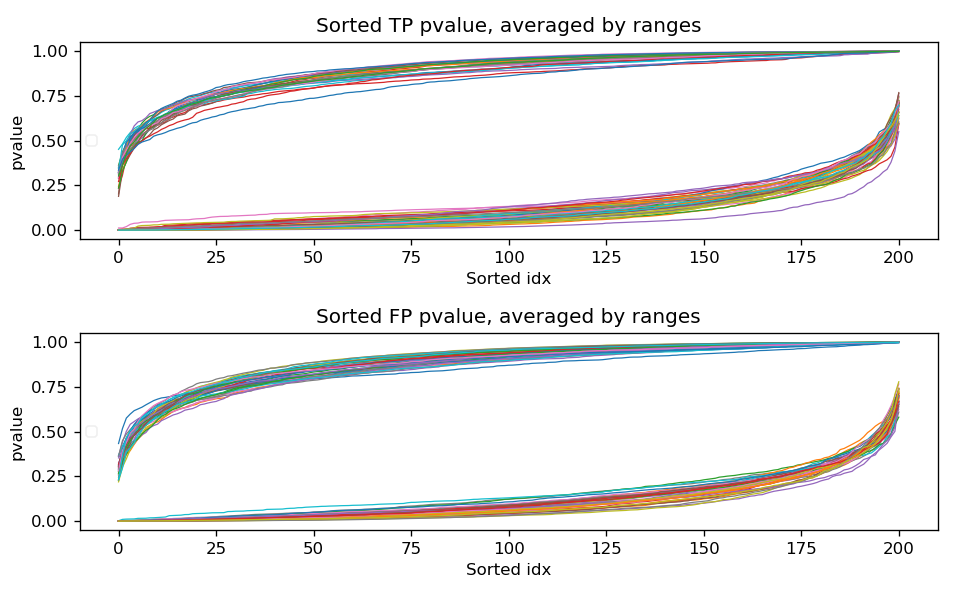

In [26]:
boot_idx, step_idx = 4, 9999 # (step_idx not used, must fail if selected)

# Processing
# bvs = tt_step_per_boot[boot_idx]  # tt value distribution per boot
bvs = tp_step_per_boot[boot_idx]   # tt-pv value distribution per boot
kspv = ksp_per_boot[boot_idx]

# (ranges, points, boots) aggregates into (points, boots)
bvs_sorted = np.sort(bvs, axis=2)      # sort by boots
bvs_avg = np.mean(bvs_sorted, axis=0)  # mean by ranges
res = bvs_avg                          # (pt, boot)
kspv_avg = np.mean(kspv, axis=0)

pt_num, boot_cnt = res.shape
x_axis = np.arange(boot_cnt)
mid_idx = 2*x_axis[len(x_axis)//4]

tf = res[::2].T[mid_idx]
l2 = len(tf[np.where(tf >= 0.5)]), len(tf[np.where(tf < 0.5)])
print("TP GT 0.5: {}, LT 0.5: {}".format(*l2))

tf = res[1::2].T[mid_idx]
l2 = len(tf[np.where(tf >= 0.5)]), len(tf[np.where(tf < 0.5)])
print("FP GT 0.5: {}, LT 0.5: {}".format(*l2))

fig, axs = plt.subplots(2, sharey=True, figsize=(8, 5))
for a in axs: a.set(xlabel='Sorted idx', ylabel='pvalue')

# pv distribution for TP (even, green) and FP (odd, red)
axs[0].set_title('Sorted TP pvalue, averaged by ranges')
for j in range(0, pt_num, 2):
    y = res[j]
#     l = 'pt: {}, ks: {:9.3}, tt: {:5.3}'.format(j, kspv_avg[j], tt_orig[j])
    axs[0].plot(x_axis, y, linewidth=0.75)#, zorder = j, label=l)

axs[1].set_title('Sorted FP pvalue, averaged by ranges')
for j in range(1, pt_num, 2):
    y = res[j]
#     l = 'pt: {}, ks: {:9.3}, tt: {:5.3}'.format(j, kspv_avg[j], tt_orig[j])
    axs[1].plot(x_axis, y, linewidth=0.75)#, zorder = j, label=l)

for a in axs: a.legend(loc=6, framealpha=0.3, fontsize=8)
fig.tight_layout()
plt.show()

In [27]:
# Creating heatmap (slower)
dbins = np.linspace(0.0, 1.0, 101)
hmap  = np.zeros((2, len(dbins), len(x_axis)))

for j, r in enumerate(res):
    rd = np.digitize(r, dbins)
    for i, d in enumerate(rd):
        hmap[j%2][d, i] += 1


<IPython.core.display.Javascript object>


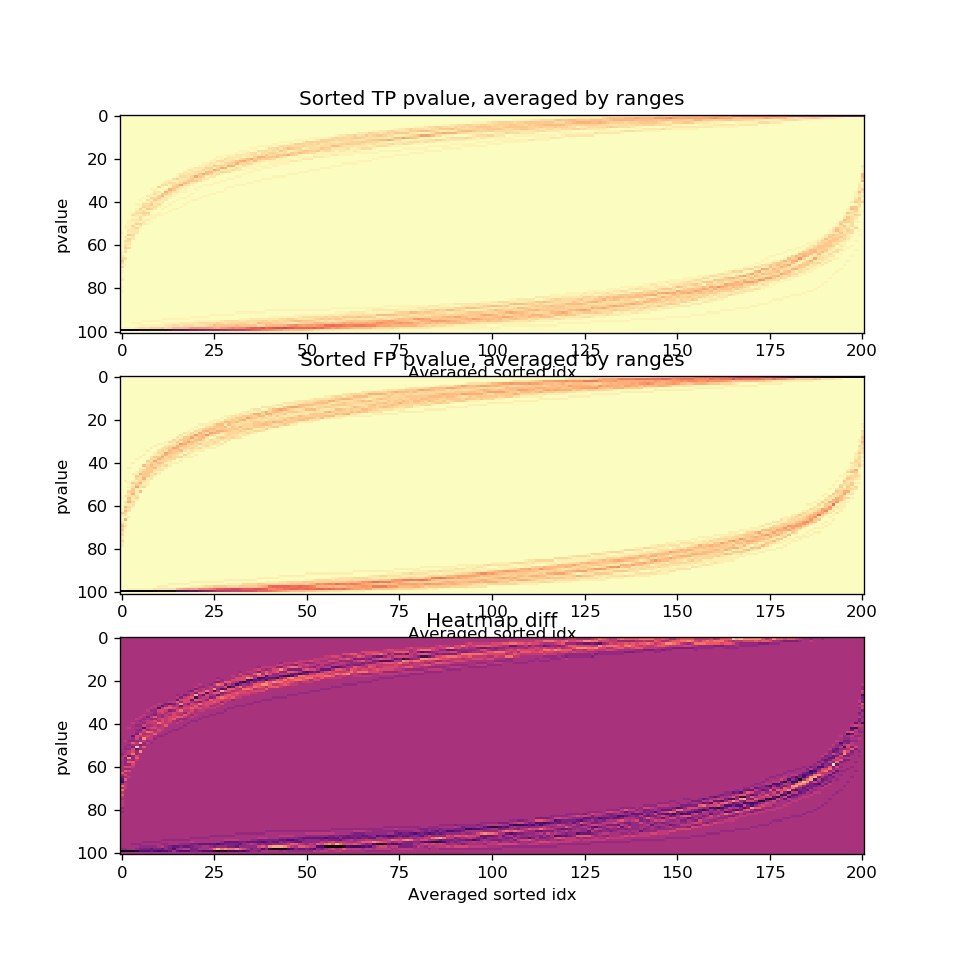

In [28]:
fig, axs = plt.subplots(3, sharey=True, figsize=(8, 8))
for a in axs: a.set(xlabel='Averaged sorted idx', ylabel='pvalue')
# for a in axs: a.set_ylim(0.0, 1.0)

mf = np.flip(hmap[0], axis=0)
axs[0].set_title('Sorted TP pvalue, averaged by ranges')
axs[0].imshow(mf, cmap='magma_r', interpolation='nearest', aspect='auto')

mf = np.flip(hmap[1], axis=0)
axs[1].set_title('Sorted FP pvalue, averaged by ranges')
axs[1].imshow(mf, cmap='magma_r', interpolation='nearest', aspect='auto') #gist_heat_r

mf = np.flip(np.array(np.abs(hmap[0]) - np.abs(hmap[1])), axis=0)
axs[2].set_title('Heatmap diff')
axs[2].imshow(mf, cmap='magma_r', interpolation='nearest', aspect='auto') #gist_heat_r

plt.show()


# Below are cells to debug code snippets

## Debugging ks-test 

In [ ]:
# Find out whether it follows the uniform distribution
ksp_per_step2 = np.zeros_like(tp_full_per_step[:,1])

for s, bps in enumerate(tp_full_per_step):          # step
    bpsr = bps.T                                    # -> (pt, boot)
    start = time.time()
    print('{}: Step {} ...'.format(bpsr.shape, s))
    for i, ptbt in enumerate(bpsr):
        d, kpv = f.kstest(ptbt, ld_cdf)
        ksp_per_step2[s, i] = kpv
    print("Done in {}".format(time.time() - start))


## Debugging distributions for kstest

In [ ]:
step_idx = 2

# bpvs = tt_boots_per_step[step_idx].T  # t
bpvs = tp_boots_per_step[step_idx].T   # t-pv
bvs = tt_boots_per_step[step_idx][boot_idx].T  # tt value distribution per step per boot

kpvs = []
ld_stat = stats.uniform
# ld_stat = stats.norm
ld_cdf = ld_stat().cdf

for j in range(0, len(bpvs)):
    bp = bpvs[j]
    d, pv = f.kstest(bp, ld_cdf)
    l, s = leak_dist.fit(bp)      # loc and scale of the dist at the point
    leaking = pv < 0.05           # 3 sigma assurance the point is leaking (non uniform)
    kpvs.append([d, pv, l, s, leaking])
d, pv = f.kstest(bpvs[mpi], ld_cdf)
l, s = leak_dist.fit(bpvs[mpi])  # loc and scale of the dist at the max leak point
leaking = pv < 0.05
kpvs.append([d, pv, l, s, leaking])

# print("d, pv, l, s, leaking")
# print(np.array(kpvs))
    
# norm_cdf = norm(loc=0, scale=1).cdf
# dt, pv  = stats.kstest(bpvs, norm_cdf)

fig = plt.figure()
plt.xlabel('Boot Number')
for j in range(0, len(bpvs), 20):
    plt.plot(bpvs[j], color = 'grey', linewidth=0.5, zorder = j)

# mpi = 0
# plt.plot(bpvs[mpi], color = 'r', linewidth=2, zorder=255)
plt.show()

In [ ]:
import numpy as np
x = np.random.random(1000)
y = np.random.random(1000)
z = np.random.random(1000)
nbins = 10
H, [bx, by, bz]=np.histogramdd((x,y,z),bins=(nbins,nbins,nbins),range=((0,1),(0,1),(0,1)))


In [ ]:
dbins    = np.linspace(0.0, 1.0, 11)
discreet = np.digitize(res[0], dbins)
hist_    = np.histogram(res[0], 10, (0.0, 1.0))
hist     = np.histogram(res[0], bins=dbins)
